In [4]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [5]:
# Creating a dataset with range separated values
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [6]:
dataset = tf.data.Dataset.range(10)
# To make windows from the above values
# 5 is the size of the window
# shift=1 is the shift value from one window to another 
dataset = dataset.window(5, shift=1)
for window in dataset:
    for val in window:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [7]:
# To get rid of the windows less than 5 we add drop_remainder = True
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window in dataset:
    for val in window:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
# To flatten the dataset into batches of 5
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [9]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
# To split the data into x and y
# :-1 is all but the last column
# -1: is the last column only
dataset = dataset.map(lambda window:(window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


Sequence bias is when the order of things can impact the selection of things. For example, if I were to ask you your favorite TV show, and listed "Game of Thrones", "Killing Eve", "Travellers" and "Doctor Who" in that order, you're probably more likely to select 'Game of Thrones' as you are familiar with it, and it's the first thing you see. Even if it is equal to the other TV shows. So, when training data in a dataset, we don't want the sequence to impact the training in a similar way, so it's good to shuffle them up.

In [10]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window:(window[:-1], window[-1:]))
# Shuffle the data to remove sequence bias
# buffer_size is the total number of elements 0-9 = 10 
dataset = dataset.shuffle(buffer_size=10)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[2 3 4 5] [6]
[5 6 7 8] [9]
[4 5 6 7] [8]
[1 2 3 4] [5]
[3 4 5 6] [7]
[0 1 2 3] [4]


In [11]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window:(window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
# Making batches of the dataset
# Prefetch allows later elements to be prepared while the current
# element is being processed. This often improves latency and throughput.
# prefetch(1) prefetches 1 batch
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[3 4 5 6]
 [5 6 7 8]]
y =  [[7]
 [9]]
x =  [[4 5 6 7]
 [1 2 3 4]]
y =  [[8]
 [5]]
x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [[4]
 [6]]


In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [14]:
# window + 1 is done because y 
def window_dataset(series, window_size, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(buffer_size).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = window_dataset(series, window_size, batch_size, shuffle_buffer_size)
print(dataset)

# layer 0 with 1 unit because y 
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.Sequential([l0])
model.compile(loss="mse", optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100)

In [16]:
print("Layer Weights")
# 20 is the window_size so x is 20 and so 20 weights one for each value of x and 1 bias term
print(l0.get_weights())

Layer Weights
[array([[ 0.02751232],
       [-0.08347951],
       [ 0.06727271],
       [-0.0585631 ],
       [ 0.05090804],
       [-0.03402862],
       [ 0.02116225],
       [ 0.00636605],
       [ 0.0209976 ],
       [-0.03292641],
       [-0.01417187],
       [ 0.04942684],
       [-0.05745559],
       [ 0.04634394],
       [ 0.01547665],
       [ 0.0706089 ],
       [ 0.00445411],
       [ 0.21193944],
       [ 0.22066125],
       [ 0.45573667]], dtype=float32), array([0.01587905], dtype=float32)]


numpy.newaxis is used to increase the dimension of the existing array by one more dimension. 1D to 2D. 2D to 3D.
We could use numpy.expand_dims tooooooo.

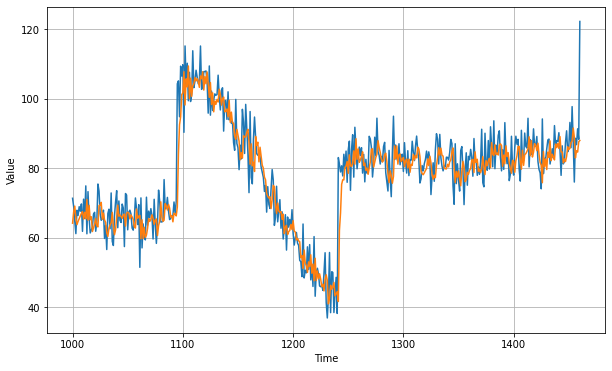

In [21]:
def forecast_series(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

results = forecast_series(series, window_size)

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.show()

In [22]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

4.923743


Nice performance with that low mae.